## QUBO Warm‑Start for the Battery MILP (24‑qubit discharge‑timing skeleton)
_A detailed tutorial on constructing a QUBO suitable for QAOA that produces an initial battery discharge schedule._

### Goal
The full battery optimization problem (joint operation of wind + battery) is mixed‑integer and nonlinear, mainly because:
- You must decide when to charge or discharge.
- SOC evolves deterministically.
- Power and energy constraints couple decisions across time.
- There are cycle and operational limits.

Solving the full MILP from a cold start may be slow or get stuck in poor branches.
A quantum warm-start uses QAOA to suggest a binary discharge timing skeleton, after which the classical solver fills in:
- exact charge/discharge magnitudes $c_t$,$d_t$
- SOC trajectory $E_t$​
- feasibility under limits
- best revenue

To keep the quantum circuit small and NISQ‑friendly, we isolate only the 24 binary timing decisions, one per hour.

We want a small QUBO (≤ 24 binary variables) that provides an initial guess for the discharge profile $d_t$, which can then be refined by a classical LP/MILP that enforces SOC dynamics and all engineering constraints.

Because of the no netting rule, the wind-scenario revenue term is constant w.r.t. battery decisions, so the battery schedule is driven by prices $p_t$ (and battery constraints). The QUBO therefore uses only $p_t$.

---

## Step 1 — Skeleton decision variables (24 qubits)

Define one binary variable per hour: $x_t \in \{0,1\}$ for $t=1,\dots,24$.

Interpretation:
- $x_t=1$ means “discharge during hour $t$”
- $x_t=0$ means “do not discharge during hour $t$”

To keep the QUBO minimal, we use a coarse discharge magnitude:
$\tilde d_t := 4x_t$ (MWh).

This yields a binary timing skeleton for discharge, which is the warm-start signal we want.

---

## Step 2 — Revenue term in QUBO form

Battery discharge revenue under the skeleton approximation is:
$\sum_{t=1}^{24} p_t \tilde d_t = \sum_{t=1}^{24} 4p_t x_t$.

A QUBO is typically a minimization, so we minimize negative revenue:
$E_{\mathrm{rev}}(x) := -\sum_{t=1}^{24} 4p_t x_t$.

---

## Step 3 — Continuity via a switching penalty

To discourage fragmented on/off behavior, add a quadratic penalty on switches:
$E_{\mathrm{sw}}(x) := \gamma \sum_{t=2}^{24} (x_t-x_{t-1})^2$, with $\gamma\ge 0$.

For binary variables, $x_t^2=x_t$, hence:
$(x_t-x_{t-1})^2 = x_t + x_{t-1} - 2x_tx_{t-1}$.

Interpretation:
- $\gamma$ acts like a cost per switch (up to scaling)
- larger $\gamma$ encourages fewer discharge blocks

---

## Step 4 — Cycle proxy as a cardinality penalty (no extra qubits)

The MILP cycle proxy is:
$\sum_{t=1}^{24} d_t \le 32$ MWh.

Under $\tilde d_t=4x_t$, this becomes:
$4\sum_{t=1}^{24} x_t \le 32$, i.e. $\sum_{t=1}^{24} x_t \le 8$.

With only 24 qubits, a standard way to enforce this without slack bits is a target-cardinality penalty:
$E_{\mathrm{card}}(x) := A\left(\sum_{t=1}^{24} x_t - K\right)^2$, with $A>0$ and $K=8$.

Notes:
- This enforces $\sum_t x_t \approx K$ (typically $\sum_t x_t = K$ if $A$ is large).
- This is a modification of the original inequality, acceptable for warm-starting because the classical refinement step will enforce SOC physics and may reshape discharges.

---

## Step 5 — Final QUBO objective

The final QUBO is:
$\min_{x\in\{0,1\}^{24}} E(x)$

with:
$E(x)=E_{\mathrm{rev}}(x)+E_{\mathrm{sw}}(x)+E_{\mathrm{card}}(x)$

i.e.:
$E(x)=-\sum_{t=1}^{24}4p_t x_t + \gamma\sum_{t=2}^{24}(x_t-x_{t-1})^2 + A\left(\sum_{t=1}^{24}x_t-K\right)^2$.

This uses exactly 24 binary variables.

---

## Step 6 — QUBO matrix form $x^\top Q x$

Write $x=(x_1,\dots,x_{24})^\top$. A QUBO can be written as:
$E(x)=x^\top Q x$,

using the convention:
$x^\top Q x = \sum_t Q_{tt}x_t + \sum_{i<j} Q_{ij}x_ix_j$.

### Diagonal terms (linear coefficients)

Define:
$\deg(t)=1$ for $t\in\{1,24\}$, and $\deg(t)=2$ for $t\in\{2,\dots,23\}$.

Then:
$Q_{tt} = -4p_t + \gamma\,\deg(t) + A(1-2K)$.

### Off-diagonal terms (quadratic couplers)

Cardinality penalty contributes for all $i<j$:
$Q_{ij} \mathrel{+}= 2A$.

Switching penalty contributes for adjacent hours:
$Q_{t-1,t} \mathrel{+}= -2\gamma$ for $t=2,\dots,24$.

Equivalently:
- if $|i-j|=1$, then $Q_{ij}=2A-2\gamma$
- if $|i-j|>1$, then $Q_{ij}=2A$

(Additive constants such as $AK^2$ can be dropped since they do not affect the minimizer.)


In [ ]:
# Load dataset
df = pd.read_csv("../data/input_data.csv")
p = df["price"].to_numpy()

# Parameters used for the 24-qubit QUBO
A = 1000.0
gamma = 100.0
K = 8

def build_qubo_upper(p, A=1000.0, gamma=100.0, K=8):
    p=np.asarray(p,float); n=len(p)
    Q=np.zeros((n,n),float)
    # revenue (discharge at 4 MWh when x_t=1)
    for t in range(n):
        Q[t,t] += -4.0*p[t]
    # switching penalty gamma * sum_{t=2..24} (x_t - x_{t-1})^2
    for t in range(n):
        deg = 1.0 if (t==0 or t==n-1) else 2.0
        Q[t,t] += gamma*deg
    for t in range(1,n):
        Q[t-1,t] += -2.0*gamma  # only upper triangle
    # cardinality penalty A*(sum x - K)^2, constant A*K^2 omitted
    lin=A*(1-2*K)
    for t in range(n):
        Q[t,t] += lin
    for i in range(n):
        for j in range(i+1,n):
            Q[i,j] += 2.0*A
    return Q

def upper_to_symmetric(Q_upper):
    Q_sym = np.array(Q_upper, float)
    n=Q_sym.shape[0]
    for i in range(n):
        for j in range(i+1,n):
            q=Q_sym[i,j]
            Q_sym[i,j]=q/2.0
            Q_sym[j,i]=q/2.0
    return Q_sym

Q_upper = build_qubo_upper(p, A=A, gamma=gamma, K=K)
Q_sym = upper_to_symmetric(Q_upper)

# Solve exactly (dynamic programming over time and number of 1s; exact for this special structure)
def solve_chain_with_count(p, gamma, m):
    T=len(p)
    C = -2.0*gamma
    L = np.zeros(T)
    for t in range(T):
        deg = 1.0 if (t==0 or t==T-1) else 2.0
        L[t] = -4.0*p[t] + gamma*deg
    
    INF=1e30
    dp = np.full((T, m+1, 2), INF)
    prev = np.full((T, m+1, 2), -1, dtype=int)
    for s in (0,1):
        k=s
        if k<=m:
            dp[0,k,s]=L[0]*s
            prev[0,k,s]=-1
    for t in range(1,T):
        for k in range(m+1):
            for s in (0,1):
                if k - s < 0:
                    continue
                best=INF; best_prev=-1
                for sp in (0,1):
                    val = dp[t-1, k-s, sp]
                    if val>=INF/2: 
                        continue
                    val2 = val + L[t]*s + C*sp*s
                    if val2 < best:
                        best = val2
                        best_prev = sp
                dp[t,k,s]=best
                prev[t,k,s]=best_prev
    s_final = int(dp[T-1,m,1] < dp[T-1,m,0])
    Emin = dp[T-1,m,s_final]
    x = np.zeros(T,dtype=int)
    k=m; s=s_final
    for t in range(T-1,-1,-1):
        x[t]=s
        sp=prev[t,k,s]
        k-=s
        s=sp if sp!=-1 else 0
    return Emin, x

def solve_qubo_skeleton(p, A, gamma, K):
    T=len(p)
    best_E=1e30
    best_x=None
    best_m=None
    for m in range(T+1):
        chain_E, x = solve_chain_with_count(p, gamma, m)
        E = chain_E + A*(m-K)**2
        if E < best_E:
            best_E=E; best_x=x; best_m=m
    return best_E, best_m, best_x

E_opt, m_opt, x_opt = solve_qubo_skeleton(p, A=A, gamma=gamma, K=K)
d0 = 4.0*x_opt

# Diagonalization (eigendecomposition) of the symmetric form
eigvals, eigvecs = np.linalg.eigh(Q_sym)

# Save artifacts
Q_upper_df = pd.DataFrame(Q_upper, index=[f"h{t}" for t in range(1,25)], columns=[f"h{t}" for t in range(1,25)])
Q_sym_df   = pd.DataFrame(Q_sym,   index=[f"h{t}" for t in range(1,25)], columns=[f"h{t}" for t in range(1,25)])

sol_df = df[["hour","price"]].copy()
sol_df["x_discharge"] = x_opt
sol_df["d0_MWh"] = d0

Q_upper_path = "../data/qubo_matrix_upper.csv"
Q_sym_path   = "../data/qubo_matrix_symmetric.csv"
sol_path     = "../data/qubo_solution.csv"

Q_upper_df.to_csv(Q_upper_path, float_format="%.6f")
Q_sym_df.to_csv(Q_sym_path, float_format="%.6f")
sol_df.to_csv(sol_path, index=False)

# Display small summaries
summary = pd.DataFrame({
    "parameter": ["A", "gamma", "K", "m_opt (sum x)", "E_opt (includes A*(m-K)^2)", "switches", "approx_discharge_revenue_EUR"],
    "value": [A, gamma, K, int(m_opt), float(E_opt), int(np.sum(x_opt[1:] != x_opt[:-1])), float(np.sum(4*p*x_opt))]
})

print("QUBO parameter summary", summary)
print("QUBO solution (x and d0 per hour)", sol_df)

eig_summary = pd.DataFrame({
    "eigval": eigvals
})
print("Eigenvalues of Q (symmetric form)", eig_summary.head(10))



---

## Step 7 — Warm start for the MILP

After solving the QUBO, decode the binary solution $x_t^\star$ and define:
$d_t^{(0)} := 4x_t^\star$.

Then run a classical projection/refinement that enforces the real battery physics:
- SOC dynamics: $E_t = E_{t-1} + \eta_{\mathrm{ch}}c_t - d_t$, with $E_0=E_{24}=0$ and $0\le E_t\le 16$
- power limits: $0\le c_t\le 5$ and $0\le d_t\le 4$
- optionally: no-reversal and/or block penalties

A typical refinement approach is:
1. Fix or encourage discharge in the hours where $x_t^\star=1$ (e.g., bounds or a deviation penalty $\sum_t |d_t-d_t^{(0)}|$).
2. Solve the resulting LP/MILP to obtain a feasible $(c_t,d_t,E_t)$.
3. Use that solution as the warm start / incumbent for the full MILP.

Pipeline summary:
$\text{MILP} \Rightarrow \text{QUBO skeleton (24 qubits)} \Rightarrow \text{LP/MILP projection} \Rightarrow \text{full MILP}$.


In [2]:
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
# from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo

from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli
import numpy as np
from qiskit.circuit.library import XXPlusYYGate
import qiskit

from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator

from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
import matplotlib.pyplot as plt
backend = FakeSherbrooke()


import numpy as np
import pandas as pd

# QAOA

In this notebook we present the QAOA step to get the initial guess in our optimization solver. In a first time we will be using a simple circuit simulator. Then, we will run this same circuit on a IQM QPU using IQM resonance

### Simple circuit simulator

In [18]:
# Example QUBO
# Load Q from qubo_matrix_symmetric.csv (assumed numeric symmetric matrix)
Q = (pd.read_csv("../data/qubo_matrix_symmetric.csv",index_col = 0).to_numpy())[0:6,0:6]
# Q = np.loadtxt("../data/qubo_matrix_symmetric.csv", delimiter=",")
# Q = np.asarray(Q)


In [19]:
Q.shape

(6, 6)

In [20]:


# Create QuadraticProgram
qp = QuadraticProgram()
n = Q.shape[0]
for i in range(n):
    qp.binary_var(name=f'x{i}')

# Add quadratic objective
objective = {}
for i in range(n):
    for j in range(n):
        if Q[i, j] != 0:
            objective[(f'x{i}', f'x{j}')] = Q[i, j]

qp.minimize(quadratic=objective)
# Convert to Ising operator
converter = QuadraticProgramToQubo()
qubo = converter.convert(qp)
operator, offset = qubo.to_ising()


In [21]:
circuit = QAOAAnsatz(cost_operator=operator, reps=1)
circuit.measure_all()

In [22]:
circuit.draw(fold = -1)

┌──────────────────┐ ░ ┌─┐               
   q_0: ┤0                 ├─░─┤M├───────────────
        │                  │ ░ └╥┘┌─┐            
   q_1: ┤1                 ├─░──╫─┤M├────────────
        │                  │ ░  ║ └╥┘┌─┐         
   q_2: ┤2                 ├─░──╫──╫─┤M├─────────
        │  QAOA(γ[0],β[0]) │ ░  ║  ║ └╥┘┌─┐      
   q_3: ┤3                 ├─░──╫──╫──╫─┤M├──────
        │                  │ ░  ║  ║  ║ └╥┘┌─┐   
   q_4: ┤4                 ├─░──╫──╫──╫──╫─┤M├───
        │                  │ ░  ║  ║  ║  ║ └╥┘┌─┐
   q_5: ┤5                 ├─░──╫──╫──╫──╫──╫─┤M├
        └──────────────────┘ ░  ║  ║  ║  ║  ║ └╥┘
meas: 6/════════════════════════╩══╩══╩══╩══╩══╩═
                                0  1  2  3  4  5

In [23]:
def cost_fun_estimator(params, ansatz, hamiltonian, estimator):
    # we map the hamiltonian to the device
    isa_hamiltonian = hamiltonian.apply_layout(layout=ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)

    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)

    return cost


# service = QiskitRuntimeService()
#backend = service.least_busy(operational=True,simulator=False)
#aer_backend = AerSimulator.from_backend(backend)
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuit = pm.run(circuit)
isa_circuit.draw(fold = -1)

/Users/yanislefur/Documents/IQM_Hackathon/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


global phase: 5π/4
             ┌────┐  ┌─────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ┌──────┐ ┌───────────────┐    ┌────────┐    ┌────┐  ┌────────┐ ┌──────┐┌───────────────────┐┌─────────┐   ┌────┐       ┌────────┐              ┌──────┐  ┌─────────┐   ┌────┐              ┌──────┐  ┌──────────┐                       ┌──────┐    ┌────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          ░ ┌─┐               
q_5 -> 40 ───┤ √X ├──┤ Rz(π/2) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1     ├─┤ Rz(1000*γ[0]) ├────┤ Rz(-π) ├────┤ √X ├──┤ Rz(-π) ├─┤1     ├┤ Rz(10244.04*γ[0]) ├┤ Rz(π/2) ├───┤ √X ├───────┤ Rz(-π) ├──────────────┤1     ├──┤ Rz(π/2) ├───┤ √X ├──────────────┤1     ├──┤ Rz(-π/2) ├───────────────────────┤1     ├────┤ √X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [ ]:
from scipy.optimize import minimize

init_gamma = 0.05
init_beta = 0.01

init_params = [init_gamma, init_beta]*circuit.reps

objective_func_vals = [] 
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1024

    result = minimize(cost_fun_estimator,
                        x0=init_params,
                        args=(isa_circuit, operator, estimator),
                        method='COBYLA',
                        options={'maxiter':20, 'disp':True}
                         )
    
print(result)
                      


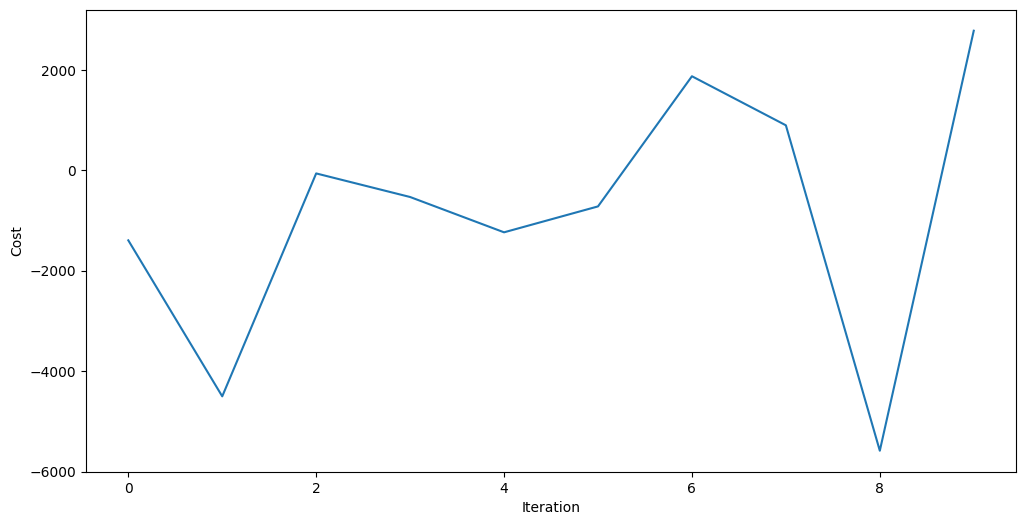

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [ ]:
optimized_circuit = isa_circuit.assign_parameters(result.x)

sampler = Sampler(mode=backend)
sampler.options.default_shots = 100_000

pub = (optimized_circuit,)
job = sampler.run([pub])
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

{11: 0.01647, 30: 0.00409, 36: 0.00916, 28: 0.00732, 5: 0.00562, 22: 0.03113, 43: 0.10873, 27: 0.05995, 45: 0.0517, 10: 0.00927, 7: 0.00724, 49: 0.00571, 37: 0.02148, 47: 0.03261, 17: 0.00657, 53: 0.04091, 51: 0.00984, 19: 0.02686, 20: 0.02889, 38: 0.01412, 55: 0.03822, 21: 0.06416, 42: 0.02239, 18: 0.00883, 58: 0.00469, 23: 0.04917, 40: 0.01212, 31: 0.01577, 62: 0.00347, 2: 0.00187, 60: 0.00495, 12: 0.00586, 50: 0.00274, 52: 0.01179, 16: 0.00381, 4: 0.00559, 59: 0.03189, 33: 0.00483, 35: 0.00678, 48: 0.00232, 13: 0.00737, 39: 0.013, 61: 0.01575, 41: 0.01295, 29: 0.01151, 56: 0.00253, 46: 0.01474, 24: 0.01001, 8: 0.00461, 44: 0.02608, 26: 0.01105, 57: 0.00546, 63: 0.01386, 54: 0.014, 1: 0.00159, 25: 0.00731, 3: 0.00596, 15: 0.00482, 9: 0.00519, 32: 0.00253, 6: 0.00366, 34: 0.00304, 14: 0.00302, 0: 0.00104}


In [ ]:
max_key = max(final_distribution_int, key=final_distribution_int.get)
max_value = final_distribution_int[max_key]
print("max_key:", max_key)
print("max_value:", max_value)
# show as binary string (n is already defined)
print("binary:", format(max_key, f'0{n}b'))

max_key: 43
max_value: 0.10873
binary: 101011
